# Project Objective

This project aims to construct a robust time series forecasting model by harnessing historical stock price data of Starbucks Corporation sourced from the Yahoo Finance API. Through time series analysis, the primary objective is to achieve precise predictions of future Starbucks open stock prices within a defined time horizon. The resulting predictive model is intended to empower investors and stakeholders with valuable insights, enabling informed decision-making by uncovering potential trends and fluctuations in Starbucks' stock value.

# Import Dependencies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima import model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

import yfinance as yf # free API to collect stock price data

import warnings
warnings.filterwarnings("ignore")

pd.options.display.float_format = '{:.6f}'.format

# Data Acquisition
Data for this project is sourced through the free Yahoo Finance API.

In [2]:
sbux = yf.Ticker("SBUX")

In [3]:
starbucks = sbux.history(period="3mo")
starbucks.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-09-20 00:00:00-04:00,94.928362,96.091974,94.530554,94.639954,4572100,0.000000,0.000000
2023-09-21 00:00:00-04:00,94.639949,94.799071,92.521585,92.591202,6108800,0.000000,0.000000
2023-09-22 00:00:00-04:00,92.919404,93.824427,92.859734,93.168037,5118900,0.000000,0.000000
2023-09-25 00:00:00-04:00,92.382351,92.959183,91.745850,92.233170,4818800,0.000000,0.000000
2023-09-26 00:00:00-04:00,91.497215,91.984535,90.681697,91.497215,6086600,0.000000,0.000000


Given the considerable day-to-day variations in stock prices influenced by numerous factors, I'll utilize a three-month historical stock price dataset to build the model.

## Data Dictionary

|Feature|Description|
|-------|------------|
|`Open`|The opening stock price at the beginning of the day.|
|`High`|The highest stock price during the day.|
|`Low`|The lowest stock price during the day.|
|`Close`|The final stock price of the day.|
|`Volume`|The total number of shares traded during the day.|
|`Dividends`|The amount of dividends paid out per share during the day.|
|`Stock Splits`|The number of times a stock split occurred during the day.|

# Data Analysis

In [4]:
starbucks

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-09-20 00:00:00-04:00,94.928362,96.091974,94.530554,94.639954,4572100,0.000000,0.000000
2023-09-21 00:00:00-04:00,94.639949,94.799071,92.521585,92.591202,6108800,0.000000,0.000000
2023-09-22 00:00:00-04:00,92.919404,93.824427,92.859734,93.168037,5118900,0.000000,0.000000
2023-09-25 00:00:00-04:00,92.382351,92.959183,91.745850,92.233170,4818800,0.000000,0.000000
2023-09-26 00:00:00-04:00,91.497215,91.984535,90.681697,91.497215,6086600,0.000000,0.000000
...,...,...,...,...,...,...,...
2023-12-13 00:00:00-05:00,98.500000,98.639999,96.820000,98.110001,7741900,0.000000,0.000000
2023-12-14 00:00:00-05:00,98.720001,98.790001,97.150002,97.839996,9764800,0.000000,0.000000
2023-12-15 00:00:00-05:00,97.839996,98.239998,96.559998,96.750000,12463800,0.000000,0.000000


In [5]:
starbucks = starbucks.reset_index()

In [6]:
starbucks

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2023-09-20 00:00:00-04:00,94.928362,96.091974,94.530554,94.639954,4572100,0.000000,0.000000
1,2023-09-21 00:00:00-04:00,94.639949,94.799071,92.521585,92.591202,6108800,0.000000,0.000000
2,2023-09-22 00:00:00-04:00,92.919404,93.824427,92.859734,93.168037,5118900,0.000000,0.000000
3,2023-09-25 00:00:00-04:00,92.382351,92.959183,91.745850,92.233170,4818800,0.000000,0.000000
4,2023-09-26 00:00:00-04:00,91.497215,91.984535,90.681697,91.497215,6086600,0.000000,0.000000
...,...,...,...,...,...,...,...,...
59,2023-12-13 00:00:00-05:00,98.500000,98.639999,96.820000,98.110001,7741900,0.000000,0.000000
60,2023-12-14 00:00:00-05:00,98.720001,98.790001,97.150002,97.839996,9764800,0.000000,0.000000
61,2023-12-15 00:00:00-05:00,97.839996,98.239998,96.559998,96.750000,12463800,0.000000,0.000000
62,2023-12-18 00:00:00-05:00,97.239998,97.320000,95.919998,96.559998,6146400,0.000000,0.000000


In [7]:
def format_dataframe(df):
    """This function restructures the dataframe for improved visualization."""
    try:
        df = df.reset_index()
        df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
        df['Date'] = pd.to_datetime(df['Date'])
        df['Month_Date'] = df['Date'].dt.strftime('%m-%d')
        df = df.set_index('Date')
        df.drop(columns=['index'], inplace=True)
        return df
    except:
        df = df.reset_index()
        df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
        df['Date'] = pd.to_datetime(df['Date'])
        df['Month_Date'] = df['Date'].dt.strftime('%m-%d')
        df = df.set_index('Date')
        return df

In [8]:
full_df = format_dataframe(starbucks)

In [30]:
# full_df.to_csv("sbux_stockprice.csv", index=False)

In [9]:
full_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Month_Date
Date,,,,,,,,
2023-09-20,94.928362,96.091974,94.530554,94.639954,4572100,0.000000,0.000000,09-20
2023-09-21,94.639949,94.799071,92.521585,92.591202,6108800,0.000000,0.000000,09-21
2023-09-22,92.919404,93.824427,92.859734,93.168037,5118900,0.000000,0.000000,09-22
2023-09-25,92.382351,92.959183,91.745850,92.233170,4818800,0.000000,0.000000,09-25
2023-09-26,91.497215,91.984535,90.681697,91.497215,6086600,0.000000,0.000000,09-26
...,...,...,...,...,...,...,...,...
2023-12-13,98.500000,98.639999,96.820000,98.110001,7741900,0.000000,0.000000,12-13
2023-12-14,98.720001,98.790001,97.150002,97.839996,9764800,0.000000,0.000000,12-14
2023-12-15,97.839996,98.239998,96.559998,96.750000,12463800,0.000000,0.000000,12-15


In [10]:
full_df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000
mean,96.818737,97.543861,95.968112,96.648906,7519177.875000,0.008906,0.000000
std,5.102193,5.082423,5.034824,5.091479,3440400.619666,0.071250,0.000000
min,89.398747,90.572297,88.722461,88.990990,3206400.000000,0.000000,0.000000
25%,92.347544,93.177977,91.459920,92.218252,5393625.000000,0.000000,0.000000
50%,96.014999,97.014999,95.160000,95.990002,6757350.000000,0.000000,0.000000
75%,101.622501,102.310001,100.185576,101.407255,7994450.000000,0.000000,0.000000
max,107.180000,107.660004,106.199997,107.209999,23396300.000000,0.570000,0.000000


Utilizing the Pandas 'describe' method, we observed that the lowest opening price for Starbucks stock over the three-month period from 12/19/2023 was approximately 89.40 US dollars, while the highest reached 107.18 US dollars. The mean price stood at 97.54 US dollars. Notably, the opening stock price on 12/19/2023 was 96.94 US dollars, a value close to this mean.

The standard deviation of the opening price hovers around 4 US dollars, indicating moderate variability. Additionally, the highest dividend recorded was 57 cents.

Moving ahead, our focus will be solely on the original dataframe's opening stock prices.

In [11]:
open_price = full_df[['Open']]

In [12]:
open_price

,Open
Date,
2023-09-20,94.928362
2023-09-21,94.639949
2023-09-22,92.919404
2023-09-25,92.382351
2023-09-26,91.497215
...,...
2023-12-13,98.500000
2023-12-14,98.720001
2023-12-15,97.839996


In [13]:
open_price.describe()

,Open
count,64.000000
mean,96.818737
std,5.102193
min,89.398747
25%,92.347544
50%,96.014999
75%,101.622501
max,107.180000


In [14]:
open_price = format_dataframe(open_price)

In [15]:
open_price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 64 entries, 2023-09-20 to 2023-12-19
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        64 non-null     float64
 1   Month_Date  64 non-null     object 
dtypes: float64(1), object(1)
memory usage: 1.5+ KB


In [16]:
open_price

,Open,Month_Date
Date,,
2023-09-20,94.928362,09-20
2023-09-21,94.639949,09-21
2023-09-22,92.919404,09-22
2023-09-25,92.382351,09-25
2023-09-26,91.497215,09-26
...,...,...
2023-12-13,98.500000,12-13
2023-12-14,98.720001,12-14
2023-12-15,97.839996,12-15


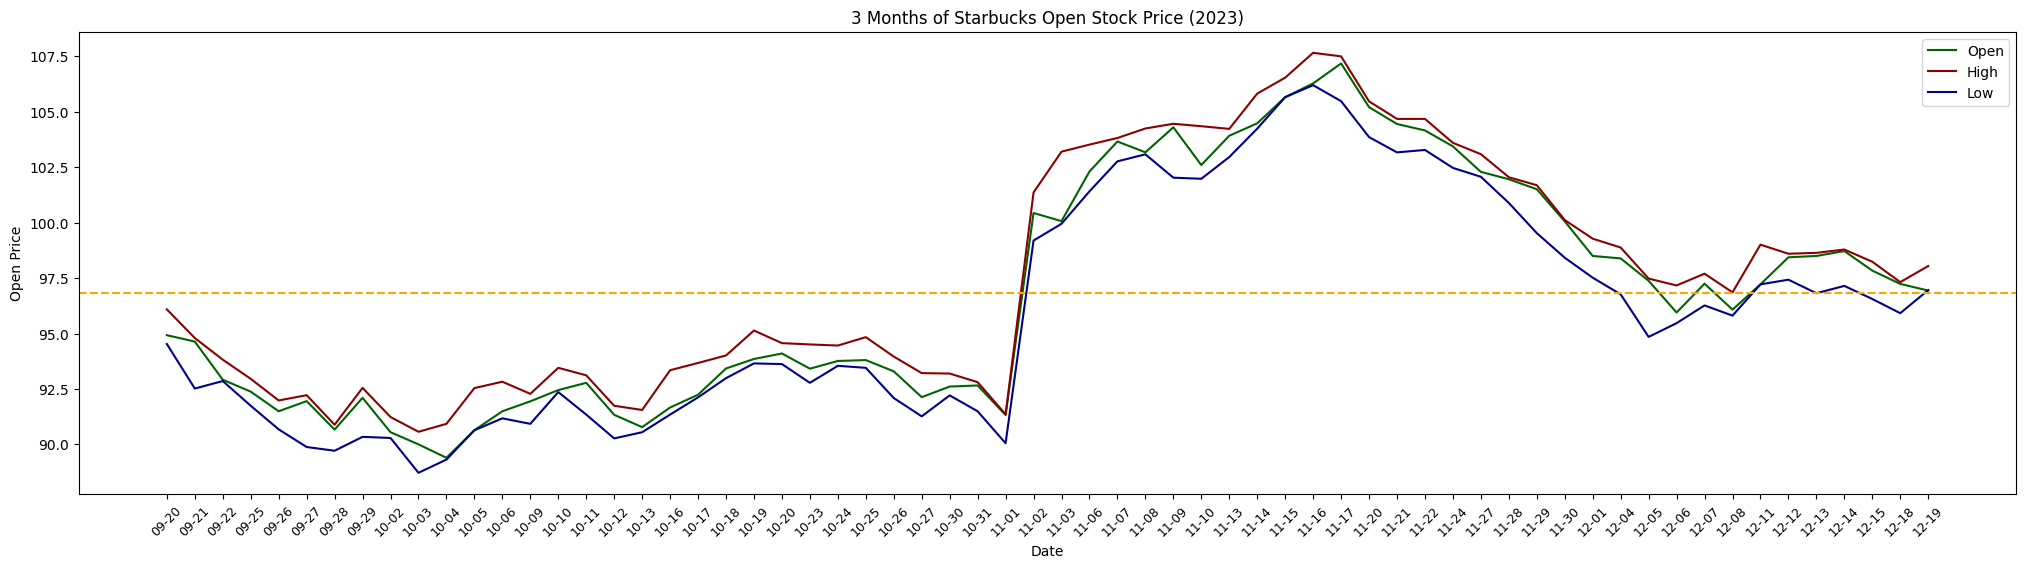

In [17]:
plt.figure(figsize=(25,6))
sns.lineplot(data=full_df, x="Month_Date", y="Open", c='darkgreen', label="Open")
sns.lineplot(data=full_df, x="Month_Date", y="High", c='darkred', label="High")
sns.lineplot(data=full_df, x="Month_Date", y="Low", c='darkblue', label="Low")
plt.axhline(y=open_price['Open'].mean(), linestyle='--', c="orange")
plt.xticks(rotation=45, fontsize=9)
plt.xlabel("Date")
plt.ylabel("Open Price")
plt.legend()
plt.title("3 Months of Starbucks Open Stock Price (2023)")
plt.show()

Analyzing the visualization above, it's evident that the stock price remained relatively stable until a sudden drop on November 1st followed by a significant surge on November 2nd. This drastic change prompts a closer investigation into the underlying reasons for such rapid fluctuations within a day.

Notably, on November 2nd, 2023, according to an Investopedia article, Starbucks' stock price surged due to a substantial increase in revenue for the quarter ending on October 1st. This surge set a new record attributed to heightened coffee prices, incorporating diverse drink variations including cold foams, various milks, syrups, and added espresso shots. Additionally, reports highlighted increased sales in China following the country's reopening after COVID-19 closures. CNN reported an 11% revenue increase, reaching a record $9.4 billion.

However, subsequent to the initial rise in early November, the stock price declined around mid-November and continued to decrease steadily. Various news reports cited third-party claims of slowing sales contributing to this decline, even during the holiday season.

Other factors contributing to the stock price drop might include potential boycotts and the emergence of a new competitor, Luckin Coffee, in China.

This analysis of the stock's rise and fall reveals the complexity of predicting stock prices, heavily influenced by external variables. The visualization portrays periods of stability, as seen between September 20th to October 31st or from December 4th to December 19th, in contrast to the volatile periods observed.

In [18]:
open_price

,Open,Month_Date
Date,,
2023-09-20,94.928362,09-20
2023-09-21,94.639949,09-21
2023-09-22,92.919404,09-22
2023-09-25,92.382351,09-25
2023-09-26,91.497215,09-26
...,...,...
2023-12-13,98.500000,12-13
2023-12-14,98.720001,12-14
2023-12-15,97.839996,12-15


In [21]:
open_price["Open"].tail(10)

Date
2023-12-06   95.949997
2023-12-07   97.250000
2023-12-08   96.080002
2023-12-11   97.220001
2023-12-12   98.440002
2023-12-13   98.500000
2023-12-14   98.720001
2023-12-15   97.839996
2023-12-18   97.239998
2023-12-19   96.940002
Name: Open, dtype: float64

In [22]:
train = open_price.loc[:"2023-12-05"]
test = open_price.loc["2023-12-06":]

In [24]:
train.drop(columns="Month_Date", inplace=True)
test.drop(columns="Month_Date", inplace=True)

In [27]:
train.shape, test.shape

((54, 1), (10, 1))

In [28]:
train.head()

,Open
Date,
2023-09-20,94.928362
2023-09-21,94.639949
2023-09-22,92.919404
2023-09-25,92.382351
2023-09-26,91.497215


In [46]:
test.head()

,Open
Date,
2023-12-06,95.949997
2023-12-07,97.250000
2023-12-08,96.080002
2023-12-11,97.220001
2023-12-12,98.440002


We'll proceed by dividing the dataframe based on specific dates. The training data, used to train the time series model, will cover the period from September 20th, 2023, to December 5th, 2023. Meanwhile, the test data, utilized for model evaluation, will span from December 6th, 2023, to December 19th, 2023.

# Data Preparation

We'll now apply the <font color='red'>**Dickey-Fuller Test**</font> to determine the stationarity of this time series data. This step is crucial as many time series models assume stationarity in the dataset. There exist four essential components in time series analysis:

- Trend: It captures the overall direction, whether the series is increasing or decreasing over time.
- Seasonality: Represents periodic behaviors, such as increased sales of swimsuits during summer compared to winter.
- Residuals: These are the random fluctuations that remain after removing the trend and seasonality components.
- Stationarity: Indicates a constant mean and variance in the series.

Upon reviewing the previous visualization, we notice a non-constant variance. The variance remained steady until early November when fluctuations and an increase in stock price occurred. Below, we'll conduct the Dickey-Fuller Test to verify the non-stationarity of the data.

In [35]:
sbux_adful = adfuller(train['Open'])
sbux_adful

(-1.0590576289050346,
 0.7311201701988763,
 0,
 53,
 {'1%': -3.560242358792829,
  '5%': -2.9178502070837,
  '10%': -2.5967964150943397},
 165.4438820531003)

In [36]:
sbux_adful[0], sbux_adful[4]['5%'] # test statistic, critical value at 5% level

(-1.0590576289050346, -2.9178502070837)

Based on the Dickey-Fuller unit root test conducted previously, we compared the test statistic to the critical values at the 5% level. The test statistic was found to be higher than the 5% threshold, indicating that we cannot reject the null hypothesis. As a result, we accept the null hypothesis, suggesting that the time series data is non-stationary.

Given this outcome, our next step involves transforming the data to mitigate exponential variance and address the non-stationarity issue.

In [37]:
train['log_open'] = np.log(train['Open'])

In [38]:
train.head(10)

,Open,log_open
Date,,
2023-09-20,94.928362,4.553123
2023-09-21,94.639949,4.550080
2023-09-22,92.919404,4.531732
2023-09-25,92.382351,4.525936
2023-09-26,91.497215,4.516309
2023-09-27,91.954704,4.521296
2023-09-28,90.671749,4.507246
2023-09-29,92.103883,4.522917
2023-10-02,90.552409,4.505929


In [42]:
train.describe()

,Open,log_open
count,54.000000,54.000000
mean,96.707763,4.570105
std,5.541307,0.056682
min,89.398747,4.493107
25%,92.111342,4.522998
50%,93.829405,4.541478
75%,102.303361,4.627943
max,107.180000,4.674510


After applying the log transformation, the standard deviation of `log_open` is now 0.056. This reduced standard deviation suggests a decrease in variance within the series data. Next, we'll proceed to assess the autocorrelation within the series.

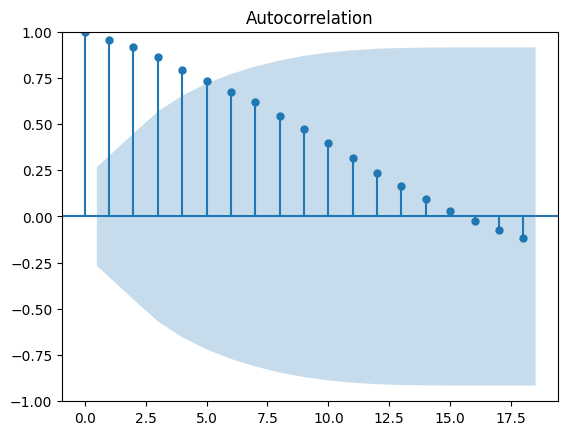

In [43]:
plot_acf(train['log_open']) # AR or p is approximately 27
plt.show()

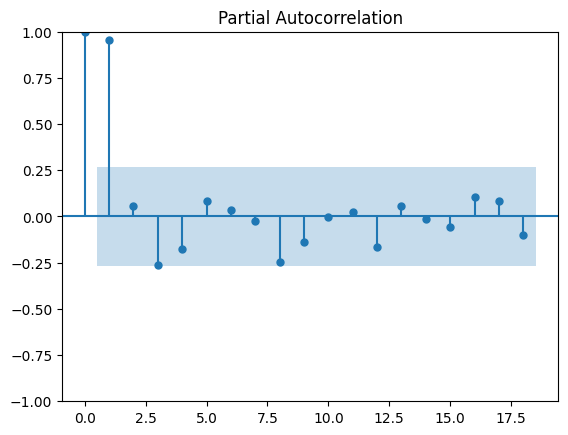

In [44]:
plot_pacf(train['log_open']) # MA or q is approximately 1
plt.show()

The <font color='green'>**Autocorrelation Plot**</font> serves to identify dependencies on previous observations, summarizing the overall correlation between a variable and its past values. This plot aids in understanding the moving average (MA or 'q' in ARIMA models).

- <font color='orange'>Moving Average</font>: involves considering the relationship between an observation and residual errors.

Our plot reveals statistically significant correlations in the last five observations, indicating their dependence on past forecast errors.

The <font color='green'>**Partial Autocorrelation Plot**</font> relates to autoregression (AR or 'p').

- <font color='orange'>Autoregression</font>: entails the dependent relationship between an observation and its preceding or 'lagged' observations, where 'lag' represents the time interval between correlated values.

Our analysis indicates that when considering all past values, only the most recent value appears to be significant concerning autoregression.

# Model (ARIMA)

In [48]:
"""The following for loop aims to assist in tuning parameters to achieve optimal performance for the ARIMA model."""

autoregg = []
integrate = []
moving_avg = []
scores = []

p_range = range(1,25)
d_range = range(1,5)
q_range = range(1,10)

for p in p_range:
    for d in d_range:
        for q in q_range:
            arima_model = model.ARIMA(train['log_open'], order=(p,d,q))
            results = arima_model.fit()

            autoregg.append(p)
            integrate.append(d)
            moving_avg.append(q)

            pred = np.exp(results.forecast(10))
            score_rmse = mean_squared_error(test, pred)**.5
            scores.append(score_rmse)

In [49]:
arima_results = pd.DataFrame({"AR":autoregg, "I":integrate, "MA":moving_avg, "RMSE":scores})

In [50]:
arima_results.sort_values(by='RMSE')

,AR,I,MA,RMSE
149,5,1,6,0.841617
40,2,1,5,0.844707
111,4,1,4,0.849009
219,7,1,4,0.853449
5,1,1,6,0.853606
...,...,...,...,...
602,17,3,9,97.422291
566,16,3,9,97.422291
782,22,3,9,97.422291
638,18,3,9,97.422291


The 'arima_result' displayed above indicates that the lowest RMSE (Root Mean Squared Error) was achieved when using p=5, d=1, and q=6 as the ARIMA model parameters.
- <font color='orange'>Inegrated</font>: signifies the process of differencing an observation from its previous observation.

In [52]:
open_price['log_open'] = np.log(open_price['Open'])

In [53]:
open_price

,Open,Month_Date,log_open
Date,,,
2023-09-20,94.928362,09-20,4.553123
2023-09-21,94.639949,09-21,4.550080
2023-09-22,92.919404,09-22,4.531732
2023-09-25,92.382351,09-25,4.525936
2023-09-26,91.497215,09-26,4.516309
...,...,...,...
2023-12-13,98.500000,12-13,4.590057
2023-12-14,98.720001,12-14,4.592288
2023-12-15,97.839996,12-15,4.583333


In [54]:
ts = open_price['log_open']

In [55]:
tuned_model = model.ARIMA(ts, order=(5,1,6))

In [56]:
fit_model = tuned_model.fit()

In [57]:
pred = np.exp(fit_model.forecast(3))
pred

64   96.728549
65   96.782498
66   96.909528
Name: predicted_mean, dtype: float64

In [59]:
pred_df = pd.DataFrame(pred)
pred_df

,predicted_mean
64,96.728549
65,96.782498
66,96.909528


In [61]:
pred_df.to_csv("stock_prediction.csv", index=False)

We've made predictions for the next three days (12/20-12/22/2023) for Starbucks stock prices. We'll compare these forecasts over the upcoming three days.